# Notebook to perform a sensitivity calculation

**Content:**
- Calculation of the collection area
- Sensitivity calculation in energy bins
- Sensitivity calculation in bins of gammaness and theta2 cuts
- Optimization of the cuts using Nex/sqrt(Nbg) -> LiMa to be implemented
- Plotting of the sensitivity in absolute values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py
import pandas as pd
import math
import pyhessio
from astropy import units as u
import eventio
from eventio.simtel.simtelfile import SimTelFile

In [5]:
simtelfile_gammas = "/home/queenmab/DATA/LST1/Gamma/gamma_20deg_0deg_run8___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"
simtelfile_protons = "/home/queenmab/DATA/LST1/Proton/proton_20deg_0deg_run194___cta-prod3-lapalma-2147m-LaPalma-FlashCam.simtel.gz"
PATH_EVENTS = "../../cta-lstchain-extra/reco/sample_data/dl2/"
file_g = PATH_EVENTS+"/reco_gammas.h5" ##Same events but with reconstructed 
file_p = PATH_EVENTS+"/reco_protons.h5"
events_g = pd.read_hdf(file_g)
events_p = pd.read_hdf(file_p)
Triggered_Events_real_gammas = events_g.shape[0]
Triggered_Events_real_protons = events_p.shape[0]

In [6]:
source_gammas = SimTelFile(simtelfile_gammas)
source_protons = SimTelFile(simtelfile_protons)

In [7]:
emin_g, emax_g = source_gammas.mc_run_headers[0]['E_range']*1e3 #GeV
spectral_index_g = source_gammas.mc_run_headers[0]['spectral_index']
num_showers = source_gammas.mc_run_headers[0]['num_showers']
num_use = source_gammas.mc_run_headers[0]['num_use']
Simulated_Events_g = num_showers * num_use
Max_impact_g = source_gammas.mc_run_headers[0]['core_range'][1]*1e2 #cm
Area_sim_g = math.pi * math.pow(Max_impact_g,2)
cone_g = source_gammas.mc_run_headers[0]['viewcone'][1]

emin_p, emax_p = source_protons.mc_run_headers[0]['E_range']*1e3 #GeV
spectral_index_p = source_protons.mc_run_headers[0]['spectral_index']
num_showers = source_protons.mc_run_headers[0]['num_showers']
num_use = source_protons.mc_run_headers[0]['num_use']
Simulated_Events_p = num_showers * num_use
Max_impact_p = source_protons.mc_run_headers[0]['core_range'][1]*1e2 #cm
Area_sim_p = math.pi * math.pow(Max_impact_p,2)
cone_p = source_protons.mc_run_headers[0]['viewcone'][1]

In [8]:
energies_g = []
energies_p = []
with SimTelFile(simtelfile_gammas) as f:
    for i, event in enumerate(f.iter_mc_events()):
        energies_g.append(event['mc_shower']['energy']*1e3) #In GeV
with SimTelFile(simtelfile_protons) as f:
    for i, event in enumerate(f.iter_mc_events()):
        energies_p.append(event['mc_shower']['energy']*1e3)

In [9]:
e_trig_g = 10**events_g.mc_energy
e_trig_p = 10**events_p.mc_energy
Triggered_Events_g = e_trig_g.shape[0] 
Triggered_Events_p = e_trig_p.shape[0]

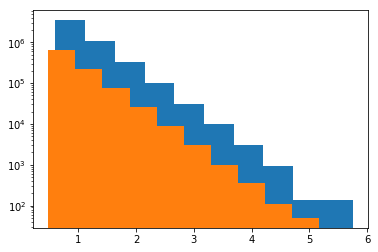

In [10]:
fig,ax = plt.subplots()
ax.hist(np.log10(energies_p),label = 'Simulated protons')
ax.hist(np.log10(energies_g),label='Simulated gammas')
ax.set_yscale("log")

In [12]:
##### Binnings and constants######
# Whenever implemented using simulated files, most of these values can be read from the simulations
eedges = 6
ebins = eedges-1
E = np.logspace(math.log10(emin_g),math.log10(emax_g),eedges)
E_trig = np.logspace(math.log10(emin_p),math.log10(100000),eedges)
Emed = np.sqrt(E[:-1] * E[1:])
Emed_trig = np.sqrt(E_trig[:-1] * E_trig[1:])
gammaness_bins = 3
theta2_bins = 3

Index_Crab = -2.62

In [13]:
##### Collection area calculation ######
def collection_area(Esim, Etrig):
    # Esim are all the simulated energies
    # Etrig are the energies after cuts
    area = []
    Nsim = np.power(Esim,Index_Crab-spectral_index_g)
    Ncuts = np.power(Etrig,Index_Crab-spectral_index_g)
    
    for i in range(0,ebins):
        Nsim_w = np.sum(Nsim[(Esim < E[i+1]) & (Esim > E[i])])
        Ntrig_w = np.sum(Ncuts[(Etrig < E[i+1]) & (Etrig > E[i])])
        if(Nsim_w == 0):
            print("You have not simulated any events in the energy range between %.3f GeV and %.3f GeV" % (E[i],E[i+1]))
            area.append(0)
        else:
            area.append(Ntrig_w / Nsim_w * Area_sim_g) # cm^2

    return area


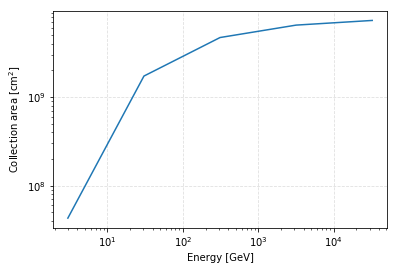

In [14]:
# Plot the collection area
area = collection_area(energies_g, e_trig_g)
fig, ax = plt.subplots()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Collection area [cm$^2$]")
ax.grid(ls='--',alpha=0.4)
ax.loglog(E[:-1], area)

In [15]:
gammaness_g = events_g.gammaness
gammaness_p = events_p.gammaness

theta2_g = (events_g.src_x-events_g.src_x_rec)**2+(events_g.src_y-events_g.src_y)**2
theta2_p = (events_p.src_x-events_p.src_x_rec)**2+(events_p.src_y-events_p.src_y)**2

In [16]:
####### Sensitivity calculation ##########
# We will first go for a implementation using Sig = Nex/sqrt(Nbg)
obstime = 50 * 3600 # s (50 hours)

In [17]:
####### Weighting of the hadrons #####
# No simulation, just take the gamma energy distribution and convert it to hadrons

#Float_t ProtonTrueSpectralIndex = -2.70;
#Float_t ProtonTrueNorm = 9.6e-9;  // (cm2 sr s GeV)^-1 at ProtonEnorm                                                                                                              
#Float_t ProtonEnorm    = 1000.; // GeV     

K = Simulated_Events_p*(1+spectral_index_p)/(emax_p**(1+spectral_index_p)-emin_p**(1+spectral_index_p))
cone = cone_p * math.pi/180
if(cone == 0):
    Omega = 1
else:
    Omega = 2*np.pi*(1-np.cos(cone))

K_w = 9.6e-11 # GeV^-1 cm^-2 s^-1                                          
index_w_p = -2.7                                                  
E0 = 1000. # GeV                                              
                                                    
Int_e1_e2 = K*E0**spectral_index_p                                                
Np_ = Int_e1_e2*(emax_p**(index_w_p+1)-emin_p**(index_w_p+1))/(E0**index_w_p)/(index_w_p+1)           
Rp = K_w*Area_sim_p*Omega*(emax_p**(index_w_p+1)-emin_p**(index_w_p+1))/(E0**index_w_p)/(index_w_p+1) # Rate (in Hz)
print("The total rate of simulated proton events is %.1f Hz" % Rp)


The total rate of simulated proton events is 8906573.8 Hz


In [18]:
####### Weighting of the gamma simulations #####

# HEGRA Crab
#  TF1* CrabFluxHEGRA = new TF1("CrabFluxHEGRA","[0]*pow(x/1000.,-[1])",50,80000);
#  CrabFluxHEGRA->SetParameter(0,2.83e-11);
#  CrabFluxHEGRA->SetParameter(1,2.62);

K = Simulated_Events_g*(1+spectral_index_g)/(emax_g**(1+spectral_index_g)-emin_g**(1+spectral_index_g))                    
Area_sim = math.pi * math.pow(Max_impact_g,2) # cm^2
cone=0
if(cone == 0):
    Omega = 1
else:
    Omega = 2*np.pi*(1-np.cos(cone))


K_w = 2.83e-11 # GeV^-1 cm^-2 s^-1                                          
index_w_g = -2.62                                                  
E0 = 1000. # GeV                                              
                                                    
Int_e1_e2 = K*E0**spectral_index_g                                                
N_ = Int_e1_e2*(emax_g**(index_w_g+1)-emin_g**(index_w_g+1))/(E0**index_w_g)/(index_w_g+1)                       
R = K_w*Area_sim_g*Omega*(emax_g**(index_w_g+1)-emin_g**(index_w_g+1))/(E0**index_w_g)/(index_w_g+1) # Rate (in Hz)
print("The total rate of simulated gamma events is %.1f Hz" % R)

The total rate of simulated gamma events is 17168202.3 Hz


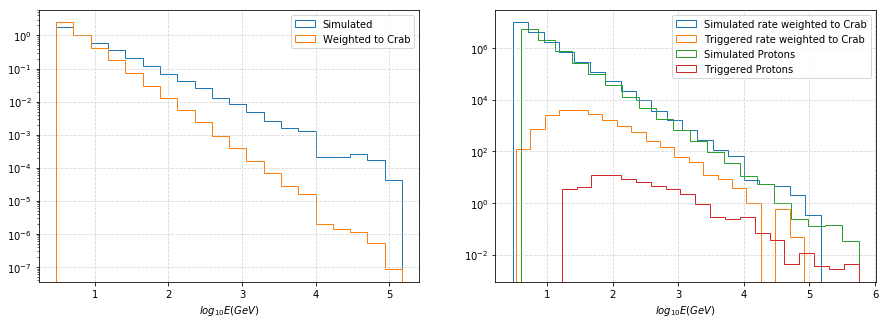

In [19]:
energies_g = np.asarray(energies_g)
energies_p = np.asarray(energies_p)
e_w = ((energies_g/E0)**(index_w_g-spectral_index_g))*R/N_
e_trig_w = ((e_trig_g/E0)**(index_w_g-spectral_index_g))*R/N_
ep_w = ((energies_p/E0)**(index_w_p-spectral_index_p))*Rp/Np_
ep_trig_w = ((e_trig_p/E0)**(index_w_p-spectral_index_p))*Rp/Np_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.hist(np.log10(energies_g),histtype=u'step',bins=20, density=1,label="Simulated")
ax1.hist(np.log10(energies_g),histtype=u'step',bins=20,weights = e_w, density=1,label="Weighted to Crab")
ax1.set_yscale('log')
#plt.xscale('log')
ax1.set_xlabel("$log_{10}E (GeV)$")
ax1.grid(ls='--',alpha=.5)
ax1.legend()

#ax2.hist(np.log10(e),histtype=u'step',bins=20,label="Simulated rate")
ax2.hist(np.log10(energies_g),histtype=u'step',bins=20,weights = e_w,label="Simulated rate weighted to Crab")
ax2.hist(np.log10(e_trig_g),histtype=u'step',bins=20,weights = e_trig_w,label="Triggered rate weighted to Crab")
ax2.hist(np.log10(energies_p),histtype=u'step',bins=20,weights = ep_w,label="Simulated Protons")
ax2.hist(np.log10(e_trig_p),histtype=u'step',bins=20,weights = ep_trig_w,label="Triggered Protons")

ax2.legend()
ax2.set_yscale('log')
ax2.set_xlabel("$log_{10}E (GeV)$")
ax2.grid(ls='--',alpha=.5)
#plt.xscale('log')

In [20]:
for i in range(0,ebins): # binning in energy
    e_w_sum = np.sum(e_w[(energies_g < E[i+1]) & (energies_g > E[i])])
    print("Rate of gammas between %.1f GeV and %.1f GeV: %.2f Hz" % (E[i],E[i+1],e_w_sum))
for i in range(0,ebins): # binning in energy
    e_w_sum = np.sum(ep_w[(energies_p < E[i+1]) & (energies_p > E[i])])
    print("Rate of protons between %.1f GeV and %.1f GeV: %.2f Hz" % (E[i],E[i+1],e_w_sum))
for i in range(0,ebins): # binning in energy
    e_w_sum = np.sum(e_trig_w[(e_trig_g < E_trig[i+1]) & (e_trig_g > E_trig[i])])
    print("Rate of triggered gammas between %.1f GeV and %.1f GeV: %.6f Hz" % (E_trig[i],E_trig[i+1],e_w_sum))
for i in range(0,ebins): # binning in energy
    e_w_sum = np.sum(ep_trig_w[(e_trig_p < E_trig[i+1]) & (e_trig_p > E_trig[i])])
    print("Rate of triggered protons between %.1f GeV and %.1f GeV: %.6f Hz" % (E_trig[i],E_trig[i+1],e_w_sum))

Rate of gammas between 3.0 GeV and 30.6 GeV: 16766451.12 Hz
Rate of gammas between 30.6 GeV and 311.7 GeV: 389846.83 Hz
Rate of gammas between 311.7 GeV and 3176.6 GeV: 9200.08 Hz
Rate of gammas between 3176.6 GeV and 32376.9 GeV: 215.26 Hz
Rate of gammas between 32376.9 GeV and 330000.0 GeV: 7.20 Hz
Rate of protons between 3.0 GeV and 30.6 GeV: 8609967.25 Hz
Rate of protons between 30.6 GeV and 311.7 GeV: 276792.36 Hz
Rate of protons between 311.7 GeV and 3176.6 GeV: 5428.90 Hz
Rate of protons between 3176.6 GeV and 32376.9 GeV: 107.92 Hz
Rate of protons between 32376.9 GeV and 330000.0 GeV: 1.07 Hz
Rate of triggered gammas between 4.0 GeV and 30.3 GeV: 8835.013896 Hz
Rate of triggered gammas between 30.3 GeV and 229.7 GeV: 8148.590852 Hz
Rate of triggered gammas between 229.7 GeV and 1741.1 GeV: 797.127299 Hz
Rate of triggered gammas between 1741.1 GeV and 13195.1 GeV: 48.895267 Hz
Rate of triggered gammas between 13195.1 GeV and 100000.0 GeV: 0.962434 Hz
Rate of triggered protons be

In [21]:
# Cut optimization for gammas and hadrons

final_gamma = np.ndarray(shape=(ebins,gammaness_bins,theta2_bins))
final_hadrons = np.ndarray(shape=(ebins,gammaness_bins,theta2_bins))

for i in range(0,eedges-1): # binning in energy
    e_w_binE = np.sum(e_w[(energies_g < E[i+1]) & (energies_g > E[i])])
    for g in range(0,gammaness_bins): # cut in gammaness
        Ngammas = []
        Nhadrons = []
        for t in range(0,theta2_bins): # cut in theta2
            e_trig_w_sum = np.sum(e_trig_w[(e_trig_g < E_trig[i+1]) & (e_trig_g > E_trig[i]) \
                                         & (gammaness_g > 0.1*g) & (theta2_g < 0.05*(t+1))])
            # Just considering all the hadrons give trigger...
            ep_w_sum = np.sum(ep_trig_w[(e_trig_p < E_trig[i+1]) & (e_trig_p > E_trig[i]) \
                                         & (gammaness_p > 0.1*g) & (theta2_p < 0.05*(t+1))])
            
            final_gamma[i][g][t] = e_trig_w_sum * obstime
            final_hadrons[i][g][t] = ep_w_sum * obstime


In [22]:
def Calculate_sensititity(Ng, Nh, alpha):
    significance = (Ng)/np.sqrt(Nh * alpha)
    sensitivity = 5/significance * 100 # percentage of Crab
    
    return sensitivity
sens = Calculate_sensititity(final_gamma, final_hadrons, 1)

In [23]:
def fill_bin_content(ax,energy_bin):
    for i in range(0,gammaness_bins):
        for j in range(0,theta2_bins):
            text = ax.text((j+0.5)*(0.5/theta2_bins), (i+0.5)*(1/gammaness_bins), "%.2E %%" % sens[energy_bin][i][j],
                       ha="center", va="center", color="w")
    return ax

In [24]:
def format_axes(ax,pl):
    ax.set_aspect(0.5)

    ax.set_ylabel(r'Gammaness',fontsize=15)
    ax.set_xlabel(r'$\theta^2$ (deg$^2$)',fontsize=15)
    
    starty, endy = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(endy, starty, 0.1)[::-1])
    startx, endx = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(startx, endx, 0.1))

    cbaxes = fig.add_axes([0.9, 0.125, 0.03, 0.755])
    cbar = fig.colorbar(pl,cax=cbaxes)
    cbar.set_label('Sensitivity (% Crab)',fontsize=15) 

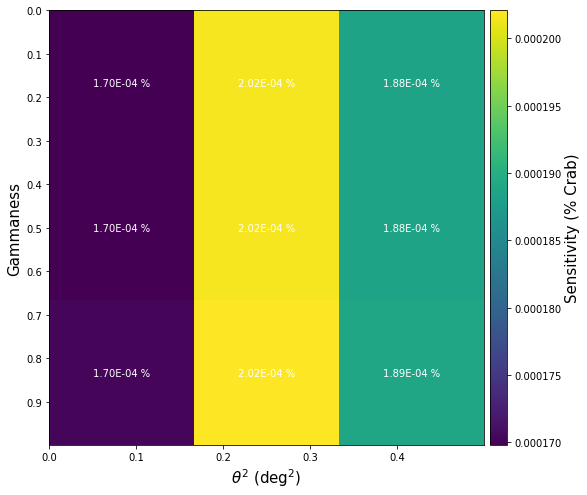

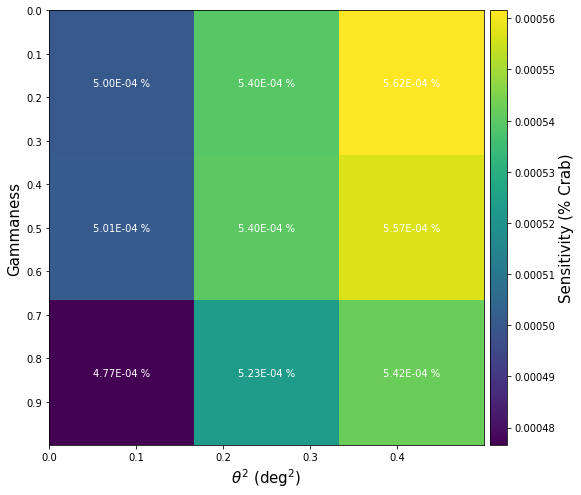

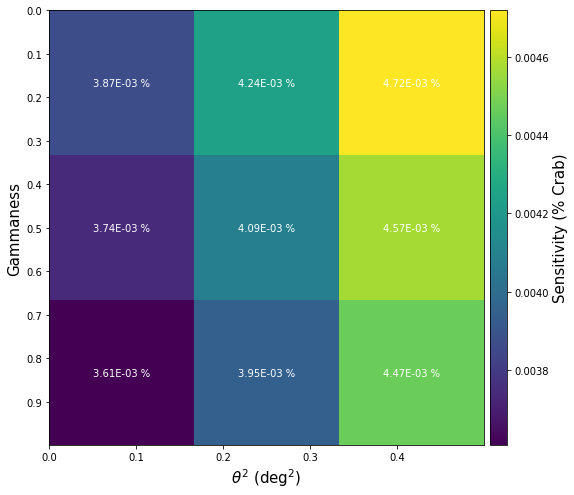

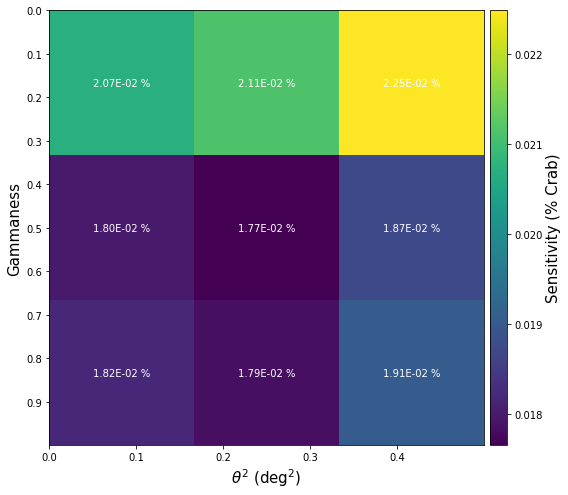

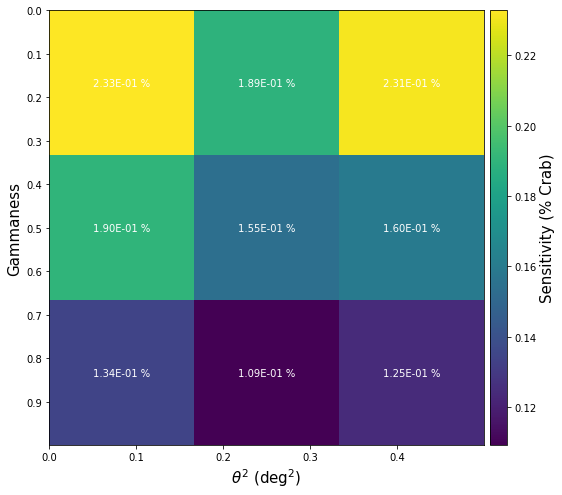

In [25]:
# Sensitivity plots for different Energy bins
for ebin in range(0,ebins):
    fig, ax = plt.subplots(figsize=(8,8))
    pl = ax.imshow(sens[ebin], cmap='viridis', extent=[0., 0.5, 1., 0.])
    fill_bin_content(ax, ebin)

    format_axes(ax, pl)

In [26]:
def Crab_spectrum(x):
    MAGIC_par=[3.23e-11, -2.47, -0.24]
    #dFdE = MAGIC_par[0]*pow(x/1.,MAGIC_par[1]+MAGIC_par[2]*np.log10(x/1.))
    dFdE = MAGIC_par[0]*pow(x/1000.,MAGIC_par[1]+MAGIC_par[2]*np.log10(x/1000.))
    
    return dFdE

In [27]:
def format_axes_array(ax, arr_i,arr_j):
    ax.set_aspect(0.5)
    if ((arr_i == 0) and (arr_j == 0)):
        ax.set_ylabel(r'Gammaness',fontsize=15)
    if ((arr_i == 3) and (arr_j == 2)):
        ax.set_xlabel(r'$\theta^2$ (deg$^2$)',fontsize=15)

    starty, endy = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(endy, starty, 0.1)[::-1])
    startx, endx = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(startx, endx, 0.1))
    
    cbaxes = fig.add_axes([0.91, 0.125, 0.03, 0.755])
    cbar = fig.colorbar(pl,cax=cbaxes)
    cbar.set_label('Sensitivity (% Crab)',fontsize=15) 

/home/queenmab/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


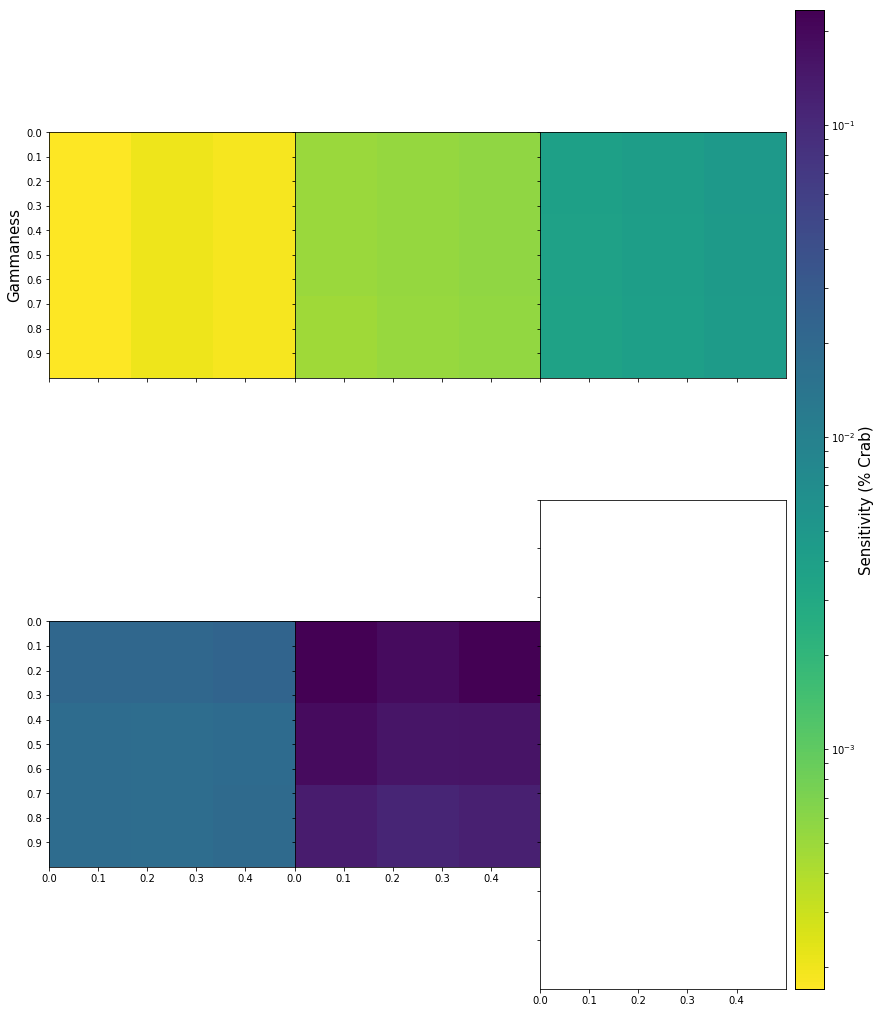

In [28]:
#fig, ax = plt.subplots(figsize=(8,8), )
fig, axarr = plt.subplots(2,3, sharex=True, sharey=True, figsize=(13.2,18))
indices=[]
sensitivity = np.ndarray(shape=ebins)

sens = sens+1e-6

for ebin in range(0,ebins):
    arr_i = int(ebin/3)
    arr_j = ebin-int(ebin/3)*3
    pl = axarr[arr_i,arr_j].imshow(sens[ebin], cmap='viridis_r', extent=[0., 0.5, 1., 0.]
                                   #vmin=sens.min(), vmax=sens.max())
                            ,norm=LogNorm(vmin=sens.min(), vmax=sens.max()))
    format_axes_array(axarr[arr_i,arr_j],arr_i,arr_j)

    # gammaness/theta2 indices where the minimum in sensitivity is reached
    ind = np.unravel_index(np.argmin(sens[sens>1e-6][ebin], axis=None), sens[ebin].shape)
    indices.append(ind)
    sensitivity[ebin] = sens[ebin][ind]
    
fig.subplots_adjust(hspace = 0, wspace = 0)
#format_axes(ax)

In [29]:
def plot_Crab(ax, percentage=100, **kwargs):
    # factor is the percentage of Crab                                                                                                                                                                      
    En = np.logspace(math.log10(100),math.log10(3.e4),40) # in TeV
    dFdE = percentage / 100. * Crab_spectrum(En)
    ax.loglog(En,dFdE * En/1.e3 * En/1.e3, color='gray', **kwargs)
    
    return ax

In [30]:
def format_axes(ax):
    ax.set_xscale("log", nonposx='clip')
    ax.set_yscale("log", nonposy='clip')
    ax.set_xlim(5e1,9.e4)
    ax.set_ylim(1.e-14,5.e-10)
    ax.set_xlabel("Energy [GeV]")
    ax.set_ylabel(r'E$^2$ $\frac{\mathrm{dN}}{\mathrm{dE}}$ [TeV cm$^{-2}$ s$^{-1}$]')
    ax.grid(ls='--',alpha=.5)

In [31]:
sensitivity

array([1.70782510e-04, 5.01415849e-04, 3.87274940e-03, 2.07289143e-02,
       2.32742961e-01])

In [32]:
Emed = Emed_trig[sensitivity>0]
def plot_sensitivity(ax):
    dFdE = Crab_spectrum(Emed)
    ax.loglog(Emed, sensitivity[sensitivity>0] / 100 * dFdE * Emed/1.e3 * Emed/1.e3, label = 'Sensitivity')

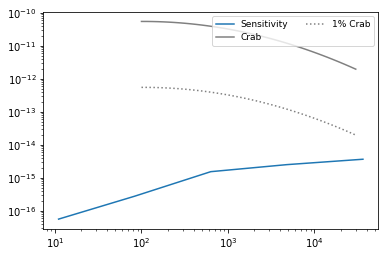

In [33]:
#### SENSITIVITY PLOT ######
fig, ax = plt.subplots()
plot_sensitivity(ax)

plot_Crab(ax, label=r'Crab')
#plot_Crab(ax,10,ls='dashed',label='10% Crab')
plot_Crab(ax,1,ls='dotted',label='1% Crab')


#format_axes(ax)
ax.legend(numpoints=1,prop={'size':9},ncol=2,loc='upper right')